In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Monthly_Workout')

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

path = './'

train=pd.read_csv(path + 'train_features.csv')
train_labels=pd.read_csv(path + 'train_labels.csv')
test=pd.read_csv(path + 'test_features.csv')
submission=pd.read_csv(path + 'sample_submission.csv')

In [4]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [5]:
#id 별로 각각 600개의 데이터가 있음을 확인   
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [6]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


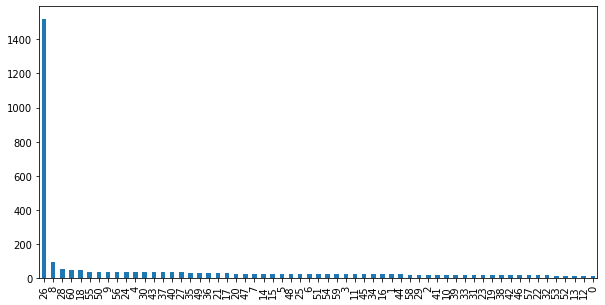

In [7]:
plt.figure(figsize=(10,5))
train_labels['label'].value_counts().plot(kind='bar')

In [8]:
# 데이터 분할
act_list=train.iloc[:,2:].columns
acc_list=['acc_x','acc_y','acc_z']
gy_list=['gy_x','gy_y','gy_z']
act_list

Index(['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [9]:
# Scaling
scaler=StandardScaler()
train[act_list]=scaler.fit_transform(train[act_list])
test[act_list]=scaler.transform(test[act_list])
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831


In [12]:
# acceleromete, gyroscope sensor feature split
def sensor_split(data):
  X_acc = []
  X_gy = []

  for i in tqdm(data['id'].unique()):
      temp_acc = np.array(data[data['id'] == i].loc[:,acc_list])
      temp_gy = np.array(data[data['id'] == i].loc[:,gy_list])
      X_acc.append(temp_acc)
      X_gy.append(temp_gy)
      
  X_acc = np.array(X_acc).reshape(-1,600,3)
  X_gy = np.array(X_gy).reshape(-1,600,3)

  return X_acc, X_gy

In [13]:
# 26(Non-exercise) data, 이 외 label data 분할
X_train_mod=pd.merge(train,train_labels,how='left',on='id')
X_train_26=X_train_mod[X_train_mod['label']==26]
X_train_n26=X_train_mod[X_train_mod['label']!=26]

display(X_train_mod)
display(X_train_26)
display(X_train_n26)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,label,label_desc
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007,37,Shoulder Press (dumbbell)
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459,37,Shoulder Press (dumbbell)
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767,37,Shoulder Press (dumbbell)
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232,37,Shoulder Press (dumbbell)
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413,37,Shoulder Press (dumbbell)
...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639,2,Bicep Curl
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377,2,Bicep Curl
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169,2,Bicep Curl
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831,2,Bicep Curl


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,label,label_desc
600,1,0,0.330644,0.141402,1.690882,0.321210,0.145228,0.092080,26,Non-Exercise
601,1,1,0.267675,0.243930,1.579862,0.457524,0.019300,0.099965,26,Non-Exercise
602,1,2,0.267617,0.273123,1.588034,0.310318,-0.048015,0.015519,26,Non-Exercise
603,1,3,0.361528,0.205227,1.634394,0.172352,-0.141140,-0.016695,26,Non-Exercise
604,1,4,0.399268,0.120432,1.704564,0.156967,-0.104579,-0.058143,26,Non-Exercise
...,...,...,...,...,...,...,...,...,...,...
1874395,3123,595,-0.399599,0.952252,-1.027387,-0.037306,-0.245940,-0.966742,26,Non-Exercise
1874396,3123,596,-0.477111,0.847710,-0.947752,-0.149804,-0.337640,-0.866939,26,Non-Exercise
1874397,3123,597,-0.524610,0.772725,-0.879577,-0.116532,-0.380954,-0.749852,26,Non-Exercise
1874398,3123,598,-0.569191,0.739435,-0.838705,0.023460,-0.395129,-0.650403,26,Non-Exercise


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,label,label_desc
0,0,0,2.307314,-0.029939,-0.432104,0.011776,-0.410859,-0.461007,37,Shoulder Press (dumbbell)
1,0,1,2.421086,-0.063321,-0.504058,0.026484,-0.528052,-0.365459,37,Shoulder Press (dumbbell)
2,0,2,2.444664,-0.056749,-0.654199,-0.037962,-0.596041,-0.366767,37,Shoulder Press (dumbbell)
3,0,3,2.428612,-0.116782,-0.573407,0.066099,-0.725311,-0.401232,37,Shoulder Press (dumbbell)
4,0,4,2.439475,-0.044220,-0.588886,0.091969,-0.784094,-0.408413,37,Shoulder Press (dumbbell)
...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.367432,-0.845648,0.503707,-0.461266,-1.413128,-1.092639,2,Bicep Curl
1874996,3124,596,-0.326315,-0.845833,0.578875,-0.474109,-1.382884,-1.097377,2,Bicep Curl
1874997,3124,597,-0.300794,-0.859728,0.652722,-0.436694,-1.341672,-1.136169,2,Bicep Curl
1874998,3124,598,-0.253120,-0.886873,0.673002,-0.367051,-1.346630,-1.148831,2,Bicep Curl


In [14]:
X_train_acc_26, X_train_gy_26= sensor_split(X_train_26)
X_train_acc_n26, X_train_gy_n26= sensor_split(X_train_n26)

X_test_acc, X_test_gy= sensor_split(test)

100%|██████████| 782/782 [00:03<00:00, 226.36it/s]


In [15]:
# 데이터 증강
# Time Warping
sigma = 0.2
knot = 4

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

def Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return(X_new)

In [16]:
def ts_aug(data, method,sigma):
  new_data=[]
  for i in range(data.shape[0]):
    temp=list(method(data[i], sigma))
    new_data.append(temp)
  return np.array(new_data)

In [17]:
X_train_acc_n26_comb = Permutation(ts_aug(X_train_acc_n26, TimeWarp, 0.2))

X_train_gy_n26_comb = Permutation(ts_aug(X_train_gy_n26, TimeWarp, 0.2))

In [18]:
y_train_26=train_labels[train_labels['label']==26]['label']
y_train_n26=train_labels[train_labels['label']!=26]['label']

In [19]:
X_train_acc_n26=np.append(X_train_acc_n26,X_train_acc_n26_comb, axis=0)

X_train_gy_n26=np.append(X_train_gy_n26,X_train_gy_n26_comb, axis=0)

y_train_total = np.append(y_train_n26,y_train_n26,axis=0)

In [20]:
X_train_acc=np.append(X_train_acc_n26,X_train_acc_26, axis=0)
X_train_gy=np.append(X_train_gy_n26,X_train_gy_26, axis=0)
y_train = np.append(y_train_total,y_train_26,axis=0)

In [21]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [22]:
sequence_length=X_train_acc.shape[1]
X_train_acc.shape

(4732, 600, 3)

In [ ]:
display(X_train_acc)
display(X_train_gy)

In [ ]:
sr = pd.Series(X_train_acc, name = ['acc_x','acc_y','acc_z'], index = [1874999:])
sr

In [ ]:
# 속도, 각속도 추가
feature_names = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']

grad_cols=[]
for col in feature_names:
    grad_cols.append(f"grad_{col}")

integ_cols = []
for col in feature_names:
    integ_cols.append(f"integ_{col}")
    
total_feature_names = feature_names + grad_cols + integ_cols

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    train.loc[train['id']==uid, grad_cols] = grad
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    grad = np.gradient(temp, axis=0)
    test.loc[test['id']==uid, grad_cols] = grad
    
print(train.shape, test.shape)
train.head()

for uid in tqdm(train['id'].unique()):
    temp = train.loc[train['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    train.loc[train['id']==uid, integ_cols] = integ
    
for uid in tqdm(test['id'].unique()):
    temp = test.loc[test['id']==uid, feature_names]
    integ = cumtrapz(temp, initial=0, axis=0)
    test.loc[test['id']==uid, integ_cols] = integ
    
print(train.shape, test.shape)
train

In [ ]:
# 가속도 feature 추가
train['acc_t']  = train.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)
test['acc_t']  = test.apply(lambda x : (x['acc_x']**2 + x['acc_y'] **2 +  x['acc_z'] ** 2 )**(1/3), axis=1)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
X.shape

In [ ]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

In [ ]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
model.add(Dense(128, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X,y, epochs=30, batch_size=128, validation_split=0.2)

In [ ]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6])
test_X.shape

In [ ]:
prediction=model.predict(test_X)

In [ ]:
prediction.shape

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

In [ ]:
submission.to_csv('baseline_aug.csv', index=False)